Major Portions of this code are copyright of their respective authors and released under the General Public License Version 3.0:
- For licensing see https://github.com/WongKinYiu/yolov7/blob/main/LICENSE.md

# Object detection with YOLOv7 in Python using OpenVINO™ Execution Provider:

1. The Object detection sample uses a YOLOv7 Deep Learning ONNX Model.


2. The sample involves presenting an image to ONNX Runtime (RT), which uses the OpenVINO™ Execution Provider to run inference on various Intel hardware devices as mentioned before and perform object detection to detect up to 80 different objects like person, bicycle, car, motorbike and much more from the coco dataset.

**Before starting with this notebook please make sure to perform the required installations as mentioned below:**
1. [YoloV7 installation requirements](https://github.com/WongKinYiu/yolov7#installation)
2. [NNCF Onnx (Experimental Requirements)](https://github.com/openvinotoolkit/nncf/tree/54a444fb6ef1806c7ab8e647f762e2547ceb95bf#installation)

## Install Requirements

### YoloV7

In [1]:
# import os

# # Uncomment and the run the below lines once, if you're running this notebook
# # for the first time in your virtual environment.
# # Note: Comment the below line and restart the notebook before proceeding further.

# if not os.path.exists('yolov7'):
#     !git clone https://github.com/WongKinYiu/yolov7  # clone
#     !cp -R yolov7/* .
#     !pip install -qr requirements.txt  # install
#     !rm -fR yolov7

**Note: You might have to restart the session before continuing. Please make sure to comment the above cells once the installations are complete and the session is restarted.**

## Download COCO validation dataset

In [2]:
import os
import torch

if not os.path.exists("../datasets"):
    # Download COCO val
    torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')
    !unzip -q tmp.zip -d ../datasets && rm tmp.zip

## Export yolov7-tiny model to ONNX format

In [3]:
if not os.path.exists("yolov7-tiny.onnx"):
    !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt
    !python export.py --weights yolov7-tiny.pt --grid --end2end --simplify --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 --img-size 640 640 --max-wh 640
if not os.path.exists('cat.jpg'):
    !wget https://storage.openvinotoolkit.org/data/test_data/images/cat.jpg

## Import Required Libraries

In [4]:
# Inference for ONNX model
import cv2
import time
import requests
import random
import logging
import numpy as np
import onnxruntime
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
import matplotlib.pyplot as plt

## Define necessary helper functions
### Pre-Processing

When we are using a pre-trained model, which is trained & fine-tuned using a fixed image size as input, we should resize our image to a shape which is expected by the model. The image reshaped using a scaling factor which is a ratio between the desired height/width and the actual image height/width.  
$$scale = min \biggl( \frac{\text{target height}}{\text{input image height}}, \frac{\text{target width}}{\text{input image width}} \biggl)$$  
Using the $scale$-factor, image height & width are calculated which is then re-shaped to the desired image size using the `opencv` package. Here this is acheived by the `image_preprocess` helper function.

In [5]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

## Labels and Colors for Lables

In [6]:
random.seed(42)
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

## Read & Pre-Process Image

In [7]:
def set_logging(rank=-1):
    logging.basicConfig(
        format="%(message)s",
        level=logging.INFO if rank in [-1, 0] else logging.WARN)
    
set_logging(5)  # run before defining LOGGER
LOGGER = logging.getLogger("yolov7")

def preProcess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    image = img.copy()
    image, ratio, dwdh = letterbox(image, auto=False)
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, 0)
    image = np.ascontiguousarray(image)

    im = image.astype(np.float32)
    im /= 255
    print("Image Shape:", im.shape, sep='\t')
    return im, ratio, dwdh

def create_session(model_path, device='CPU_FP32'):
    
    if device == 'CPU_FP32':
        providers = ['OpenVINOExecutionProvider']
    elif device == 'cpu':
        providers = ['CPUExecutionProvider']
    else:
        LOGGER.info(f'No provider passed, using default CPU EP ...')
        providers = ['CPUExecutionProvider']
    
    LOGGER.info(f'Use ORT providers: {providers}')
    
    sess = onnxruntime.InferenceSession(model_path,
                                        providers=providers,
                                        provider_options=[{'device_type': device}])

    outname = [i.name for i in sess.get_outputs()]
    inname = [i.name for i in sess.get_inputs()]
    
    return sess, outname, inname


def run_inference(model_path, img_input, device='CPU_FP32', num_runs=10, warm_up=3):
        
    img0, proces_ratio, dwdh = preProcess_image(img_input)
    session, outputs, inputs = create_session(model_path, device)
    
    pred_times = []
    inp = {inputs[0]:img0}

    
    # Inference
    for iter_num in range(num_runs + 2):

        # warmup session
        if iter_num <= warm_up:
            session.run(outputs, inp)[0]
            continue

        start = time.time()
        pred = session.run(outputs, inp)[0]
        end = time.time()
        inference_time = end - start
        pred_times.append(inference_time)
        

    ori_images = cv2.imread(img_input)
    ori_images = [cv2.cvtColor(ori_images, cv2.COLOR_BGR2RGB)]

    for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(pred):
        image = ori_images[int(batch_id)]
        box = np.array([x0,y0,x1,y1])
        box -= np.array(dwdh*2)
        box /= proces_ratio
        box = box.round().astype(np.int32).tolist()
        cls_id = int(cls_id)
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(image,box[:2],box[2:],color,2)
        cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.45,[225, 255, 255],thickness=1)
        cv2.putText(image, 'FPS: {:.8f}'.format(1.0 / inference_time),
                                  (10, 40), cv2.FONT_HERSHEY_COMPLEX, 0.45, (255, 255, 255), 0) 
    print('Avg Inference time in ms: %f' %
          (sum(pred_times) / len(pred_times) * 1000))
    plt.imshow(Image.fromarray(ori_images[0]))
    plt.axis('off')

### Inference using CPU Execution Provider (MLAS)

Image Shape:	(1, 3, 640, 640)
Avg Inference time in ms: 67.445099


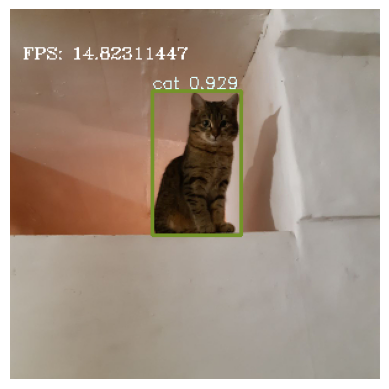

In [8]:
params = {"model_path":"yolov7-tiny.onnx",
          "img_input": "cat.jpg",
          "device":'cpu',
          "num_runs":10}

run_inference(**params)

### Inference using OpenVino Execution Provider

Image Shape:	(1, 3, 640, 640)
Avg Inference time in ms: 33.327848


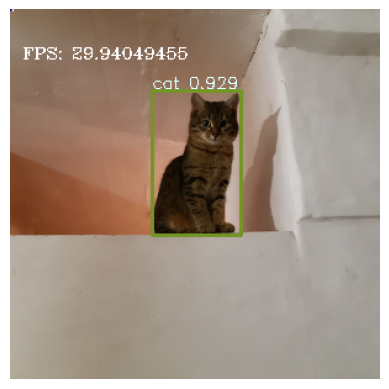

In [9]:
params = {"model_path":"yolov7-tiny.onnx",
          "img_input": "cat.jpg",
          "device":'CPU_FP32',
          "num_runs":10}

run_inference(**params)

# NNCF PTQ for YoloV7

## Quantize yolov7-tiny model

### Build PTQ API dataset

In [10]:
import onnx

from nncf.experimental.post_training.compression_builder import CompressionBuilder
from nncf.experimental.post_training.algorithms.quantization import PostTrainingQuantization
from nncf.experimental.post_training.algorithms.quantization import PostTrainingQuantizationParameters
from nncf.common.utils.logger import logger as nncf_logger
from nncf.experimental.post_training.api import dataset as ptq_api_dataset
from nncf.experimental.onnx.tensor import ONNXNNCFTensor
from utils.datasets import LoadImagesAndLabels

class YoloV7Dataset(ptq_api_dataset.Dataset):
    def __init__(self, path, batch_size, shuffle):
        super().__init__(batch_size, shuffle)
        self.load_images = LoadImagesAndLabels(path)

    def __getitem__(self, item):
        img, _, _, _ = self.load_images[item]
        # Input should be in [0,1].
        img = (1 / 255.) * img
        return {"images": ONNXNNCFTensor(img.numpy())}

    def __len__(self):
        return len(self.load_images)

dataset = YoloV7Dataset("../datasets/coco/images/val2017", 1, True)

Scanning '../datasets/coco/labels/val2017.cache' images and labels... 4952 found, 48 missing, 0 empty, 0 corrupted: 100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<?, ?it/s]


### Run PTQ

In [11]:
original_model = onnx.load("yolov7-tiny.onnx")
num_init_samples = 100
# We'll ignore detector head not to quantize them
ignored_scopes = [
    # Head branch 1
    "Mul_217",
    "Add_219",
    "Mul_221",
    "Mul_223",
    "Mul_227",
    # Head branch 2
    "Mul_251",
    "Add_253",
    "Mul_255",
    "Mul_257",
    "Mul_261",
    # Head branch 3
    "Mul_285",
    "Add_287",
    "Mul_289",
    "Mul_291",
    "Mul_295",
]
output_model_path = "yolov7-tiny-quantized.onnx"

### Step 1: Create a pipeline of compression algorithms.

In [12]:
builder = CompressionBuilder()

### Step 2: Create the quantization algorithm and add to the builder.

In [13]:
quantization_parameters = PostTrainingQuantizationParameters(
    number_samples=num_init_samples,
    ignored_scopes=ignored_scopes
)
quantization = PostTrainingQuantization(quantization_parameters)
builder.add_algorithm(quantization)

### Step 3: Execute the pipeline.

In [15]:
nncf_logger.info("Post-Training Quantization has just started!")
quantized_model = builder.apply(original_model, dataset)

INFO:nncf:Post-Training Quantization has just started!
INFO:nncf:Original opset = 12
INFO:nncf:Original ir_version = 6
INFO:nncf:Successfully converted the model to the opset = 13
ERROR:nncf:The tensor images does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 120 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 184 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 205 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 254 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 280 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 284 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 288 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nnc

ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 235 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 233 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 231 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 247 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 249 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 243 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 245 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 182 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 240 does not have shape field
ERROR:nncf:The default tensor shape will be set.
ERROR:nncf:The tensor 203 does not have sh

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]

### Step 4: Save the quantized model.

In [16]:
onnx.save(quantized_model, output_model_path)
nncf_logger.info(
    "The quantized model is saved on {}".format(output_model_path))

onnx.checker.check_model(output_model_path)

INFO:nncf:The quantized model is saved on yolov7-tiny-quantized.onnx


ValidationError: scale_images initializer name is not unique

## Run Inference on INT-8 model

### Inference using CPU Execution Provider (MLAS)

In [17]:
params = {"model_path":"yolov7-tiny-quantized.onnx",
          "img_input": "cat.jpg",
          "device":'cpu',
          "num_runs":10}

run_inference(**params)

Image Shape:	(1, 3, 640, 640)


Fail: [ONNXRuntimeError] : 1 : FAIL : Load model from yolov7-tiny-quantized.onnx failed:This is an invalid model. Error: two nodes with same node name (QuantizeLinear_images).

### Inference using OpenVino Execution Provider

In [18]:
params = {"model_path":"yolov7-tiny-quantized.onnx",
          "img_input": "cat.jpg",
          "device":'CPU_FP32',
          "num_runs":10}

run_inference(**params)

Image Shape:	(1, 3, 640, 640)


Fail: [ONNXRuntimeError] : 1 : FAIL : Load model from yolov7-tiny-quantized.onnx failed:This is an invalid model. Error: two nodes with same node name (QuantizeLinear_images).

# Benchmarking

- Benchmarks can be performed using:
    - openvino's [benchmark app](https://github.com/openvinotoolkit/openvino/tree/master/tools/benchmark_tool)
    <!-- - `onnxruntime_perf_test` tool -->


<!-- https://github.com/openvinotoolkit/open_model_zoo/tree/master/tools/accuracy_checker
accuracy_check -c path/to/configuration_file -m /path/to/models -s /path/to/source/data -a /path/to/annotation -->